In [1]:
import torch
import gym
import torch.nn as nn
import torch.optim as optim
from torch.distributions import Categorical
from functools import reduce
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal
import random
from IPython.display import clear_output
from multiprocessing.pool import ThreadPool
import cv2

In [2]:
class ActorNet(nn.Module):
    def __init__(self,input_dim,output_dim):
        super(ActorNet,self).__init__()
        self.cn1 = nn.Conv2d(in_channels=1,out_channels=128,kernel_size=2,stride=1,padding=0)
        self.tanh1 = nn.ReLU()
#         self.mx1 = nn.MaxPool2d(2)
        self.cn2 = nn.Conv2d(in_channels=128,out_channels=64,kernel_size=2,stride=1,padding=0)
        self.tanh2 = nn.ReLU()
#         self.mx2 = nn.MaxPool2d(2)
        self.cn3 = nn.Conv2d(in_channels=64,out_channels=16,kernel_size=2,stride=1,padding=0)
        self.tanh3 = nn.ReLU()
#         self.mx3 = nn.MaxPool2d(2)
        self.fc1 = nn.Linear((input_dim[0]-3) * (input_dim[1]-3) * 16,output_dim)
        
    def forward(self,obj,action=False,max_act=False):
        x = torch.FloatTensor(obj).view(-1,1,input_dim[0],input_dim[1])
        x = self.tanh1(self.cn1(x))
        x = self.tanh2(self.cn2(x))
        x = self.tanh3(self.cn3(x))
        x = x.view(-1,(input_dim[0]-3) * (input_dim[1]-3) * 16)
        logits = self.fc1(x)
        m = Categorical(logits=logits)
        act = m.sample()
        log_p = m.log_prob(act)
        if action:
            return m.log_prob(torch.LongTensor(action))
        else:
            if max_act:
                return torch.argmax(logits).item()
            else:
                return m,act.item(),log_p

In [3]:
make = 'Breakout-v0'

In [4]:
env = gym.make(make)

In [5]:
output_dim = env.action_space.n

In [23]:
class CriticNet(nn.Module):
    def __init__(self,input_dim):
        super(CriticNet,self).__init__()
        self.cn1 = nn.Conv2d(in_channels=1,out_channels=128,kernel_size=2,stride=1,padding=0)
        self.tanh1 = nn.ReLU()
        self.cn2 = nn.Conv2d(in_channels=128,out_channels=64,kernel_size=2,stride=1,padding=0)
        self.tanh2 = nn.ReLU()
        self.cn3 = nn.Conv2d(in_channels=64,out_channels=16,kernel_size=2,stride=1,padding=0)
        self.tanh3 = nn.ReLU()
        self.fc1 = nn.Linear((input_dim[0]-3) * (input_dim[1]-3) * 16,1)
        
    def forward(self,obj):
        x = torch.FloatTensor(obj).view(-1,1,input_dim[0],input_dim[1])
        x = self.tanh1(self.cn1(x))
        x = self.tanh2(self.cn2(x))
        x = self.tanh3(self.cn3(x))
        x = x.view(-1,(input_dim[0]-3) * (input_dim[1]-3) * 16)
        v = self.fc1(x)
        return v

In [24]:
gamma = 0.99
lamda = 0.95
clip_ratio = 0.2
lr_pi = 1e-4
lr_v = 1e-3
target_kl = 0.01
train_pi_iter = 5
train_v_iter = 5
traj_n = 10
iters = 200

In [25]:
def disc_cuml_rew_calc(rews,gamma=gamma):
    return list(scipy.signal.lfilter([1], [1, float(-gamma)], rews[::-1], axis=0)[::-1])

In [26]:
obj = env.reset()

In [27]:
obj.shape

(210, 160, 3)

In [28]:
obj = obj[32:193,8:152,:]

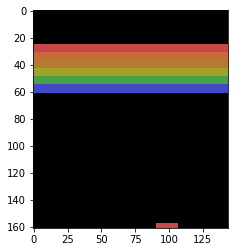

In [29]:
plt.imshow(obj)

In [30]:
obj_gray = cv2.cvtColor(cv2.resize(obj, (84, 110)), cv2.COLOR_BGR2GRAY)

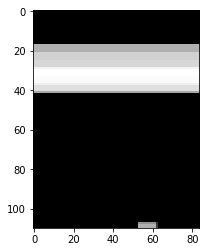

In [31]:
plt.imshow(obj_gray,cmap='gray')

In [32]:
obj_gray.shape

(110, 84)

In [33]:
input_dim = obj_gray.shape

In [34]:
def image_process(obj):
    obj = obj[32:193,8:152,:]
    obj_gray = cv2.cvtColor(cv2.resize(obj, (84, 110)), cv2.COLOR_BGR2GRAY)
    return obj_gray

In [35]:
act_net = ActorNet(input_dim,output_dim)
crit_net = CriticNet(input_dim)
optim_actor = optim.Adam(params=act_net.parameters(),lr=lr_pi)
optim_critic = optim.Adam(params=crit_net.parameters(),lr=lr_v)

In [36]:
def traject(t):
    traj = []
    rews = []
    env = gym.make(make)
    obj = image_process(env.reset())
    done = False
    while not done:
        v = crit_net.forward(obj)
        m,act,log_p = act_net.forward(obj)
        next_obj,reward,done,_ = env.step(act)
        next_obj = image_process(next_obj)
        traj.append([act,obj,next_obj,reward,done,log_p,v])
        rews.append(reward)
        obj = next_obj
    rews_disc_cuml_scaled = disc_cuml_rew_calc(rews)
    act,obj,_,rews,_,old_policy,v = zip(*traj)
    adv = [rews[i] + gamma*v[i+1] - v[i] for i in range(len(rews)-1)] + [0 - v[-1]]
    adv = torch.FloatTensor(adv)
    adv = disc_cuml_rew_calc(adv.numpy(),gamma*lamda)
    adv = torch.FloatTensor(adv)
    adv = (adv - adv.mean())/adv.std()
    traj = [i + [j,k] for i,j,k in zip(traj,rews_disc_cuml_scaled,adv)]
    return traj,rews

In [ ]:
rewards = []
for k in range(iters):
    print(k)
    process = ThreadPool(processes=1)
    out = process.map(traject,range(traj_n))
    process.close()
    process.join()
    trajectories,rewards_t = list(zip(*out))
    rewards.extend(rewards_t)
    trajectories = reduce(lambda a,b: a+b,trajectories)
    act,obj,_,rews,_,old_policy,v,rews_disc_cuml,adv = zip(*trajectories)
    adv = torch.FloatTensor(adv)
    old_policy = torch.FloatTensor(old_policy)

    for t in range(train_pi_iter):
        new_policy = act_net.forward(obj,action=act)
        ratio = torch.exp(new_policy-old_policy)
        clip_adv = torch.clamp(ratio, 1-clip_ratio, 1+clip_ratio) * adv
        loss_pi = -(torch.min(ratio * adv, clip_adv)).mean()
        optim_actor.zero_grad()
        loss_pi.backward()
        optim_actor.step()
        if (new_policy - old_policy).mean().item() > 1.5 * target_kl:
            print('early_stopping')
            break

    for t in range(train_v_iter):
        loss_v = ((crit_net.forward(obj) - torch.FloatTensor(rews_disc_cuml)) ** 2).mean()
        optim_critic.zero_grad()
        loss_v.backward()
        optim_critic.step()
        
        
    if k % 10 == 0:
        clear_output(wait=True)
        print(k)
        episode_returns = [sum(i) for i in rewards]
        plt.plot(episode_returns)
        plt.show()

0


In [14]:
episode_returns = [sum(i) for i in rewards]

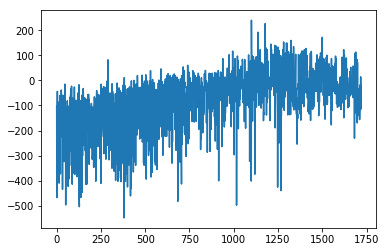

In [15]:
plt.plot(episode_returns)

In [23]:
import time

In [198]:
done = False
obj = image_process(env.reset())
rw = 0
while not done:
# for r in range(800):
#     print('**********************************')
    act = act_net.forward(obj,max_act=True)
#     time.sleep(0.02)
#     print(m.logits)
#     print(m.logits.argmax())
#     print(act)
    obj,reward,done,_ = env.step(act)
    obj = image_process(obj)
    rw += reward
    env.render()
env.close()
print(rw)

1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
0.0


In [196]:
env.close()

In [40]:
act

0

In [43]:
m.logits

tensor([-1.6989, -1.7558, -2.4567, -0.5823], grad_fn=<SubBackward0>)

In [28]:
k = torch.load('ppo_multitraj_cartpole')

In [120]:
# torch.save(act_net,'ppo_multitraj_acrobat')

C:\ProgramData\Anaconda3\lib\site-packages\torch\serialization.py:292: UserWarning: Couldn't retrieve source code for container of type ActorNet. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
C:\ProgramData\Anaconda3\lib\site-packages\torch\serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Linear. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
C:\ProgramData\Anaconda3\lib\site-packages\torch\serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Tanh. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
